# CS182 Project: Introduction to EfficientNet


### Part1: introduction
EfficientNet is a family of convolutional neural networks that were designed to provide state-of-the-art accuracy on image classification tasks while maintaining a high level of efficiency. Developed by a team of researchers at Google, EfficientNet models use a novel compound scaling method to balance the number of parameters in the network with its depth and width, resulting in a highly optimized architecture that achieves superior performance with fewer computational resources. EfficientNet models have achieved top scores in various computer vision benchmarks, including the ImageNet dataset, and have been widely adopted for a range of applications, including object detection, segmentation, and transfer learning.

In this HW, we're going to implement EfficientNet from scratch, and understand how EfficientNets are "efficient" in the sense of cost of compuation and number of parameters

Imports and preparations: (Run the cell below if you're using Google Colab)


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = '/content/gdrive/My\ Drive/cs182project_eq_efficientnet'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182project_eq_efficientnet'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install graphviz 
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

# Torch stuff
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
import torch.nn.init as init

import numpy as np
from matplotlib import pyplot as plt

#training part
import torch
from torch import nn
from torch.utils.data import DataLoader
import copy

import graphviz 
from itertools import tee

In [4]:
#@title Graphviz Utilities (run this)
def generate_dwr(csf):
  """
  Determins the depth, width and resolution from the scaling factor.
  Alpha, beta, gamma are taken from the efficientnet paper.
  """
  #From the paper
  alpha = 1.2
  beta = 1.1
  gamma = 1.15
  return (alpha ** csf, beta ** csf, gamma ** csf)

def pairwise(iterable):
  """
  Iterates through an iterable (list), pairwise.
  a, b, c -> (a,b), (b,c)
  """
  a, b = tee(iterable)
  next(b, None)
  return zip(a, b)

def compose_edges(g, nodes):
  """
  Forms the actual edges from a list of all the nodes, just sequentially.
  """
  for a, b, in list(pairwise(nodes)):
    g.edge(a, b, constraint='false')

def num_layers(n):
  # This is just a random constant
  return max(int(0.8*n), 1)

def generate_layers(g, rfactors, color, w_f, h_f, layer_name):
  """
  Generates a colored 'layer' in the graph, this could result in several
  Nodes being generated depending on the depth factor.
  """
  d, w, r = rfactors
  layers = num_layers(d)
  items = []
  for layer, index, in enumerate(range(layers)):
    name = layer_name + str(index)
    g.node(name, label = " ", color = color, style = "filled", width = str(w*w_f), height = str(r*h_f))
    items.append(name)
  return items

def generate_visualization(csf = 1):
  factors = generate_dwr(csf)
  d, w, r = factors
  g = graphviz.Digraph('efficientNet', comment='efficientNet') 
  all_items = []
  g.attr('node', shape='box')
  g.node('input','input' ,color = '#ffffff')
  all_items.append('input')
  all_items += generate_layers(g, factors, color = '#b873bf', w_f = 0.1, h_f = 0.3, layer_name = 'first')
  all_items += generate_layers(g, factors, color = '#e3c062', w_f = 0.2, h_f = 0.2, layer_name = 'second')
  all_items += generate_layers(g, factors, color = '#62e3a2', w_f = 0.2, h_f = 0.4, layer_name = 'third')
  all_items += generate_layers(g, factors, color = '#62dfe3', w_f = 0.02, h_f = 0.6, layer_name = 'fourth')
  all_items += generate_layers(g, factors, color = '#e362d0', w_f = 0.02, h_f = 0.8, layer_name = 'fifth')
  g.node('output', 'output', color = '#ffffff')
  all_items.append('output')
  compose_edges(g, all_items)
  g.attr(label=r'EfficientNet Architecture Diagram \n Compound Scaling Factor = %s' %(csf))
  return g

To better reinforce the intution about the compound scaling method, we have implemented a visualization generator function. The overall intution about just changing the compound scaling factor, then being able to affect overall change in the actual architecture, changing the depth, width, and resolution in a principled manner.

* This is intended to provide intuition about efficientNet, this is not how efficientNet literally scales.

Question: Play around with this function, at what point do you start to see new depth layers emerging? (You might also want to use this opportunity to check your intuition about the previous conceptual questions).

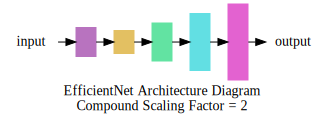

In [5]:
generate_visualization(csf = 2) #Play around with this.

We're going to use CIFAR-10 dataset for this project. It is very commonly used while testing certain CV models. The dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. We're going to use the torchvision package to load the dataset. The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

In this part we're going to implement a dataloader. The purpose of this is to build a convenient way to feed data from a dataset to a model during training or inference. With the DataLoader, users can easily handle large datasets and apply different data augmentation techniques to the input data. The PyTorch DataLoader is a flexible and efficient tool that has become a standard part of many deep learning workflows.

In [6]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_size, val_size = 40000, 10000
train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

Question 1a): setup train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset in the following block. You can use the code in the previous block as a reference.
Hint: check out function: produce_dataloader_dataset

In [9]:
#######################
# TODO: your code here#
#######################
trainloader = DataLoader(train_ds, batch_size=256,
                            shuffle=True, num_workers=2)
valloader = DataLoader(val_ds, batch_size=256, 
                            shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=256,
                            shuffle=False, num_workers=2)
#######################
#END OF YOUR CODE    #
#######################

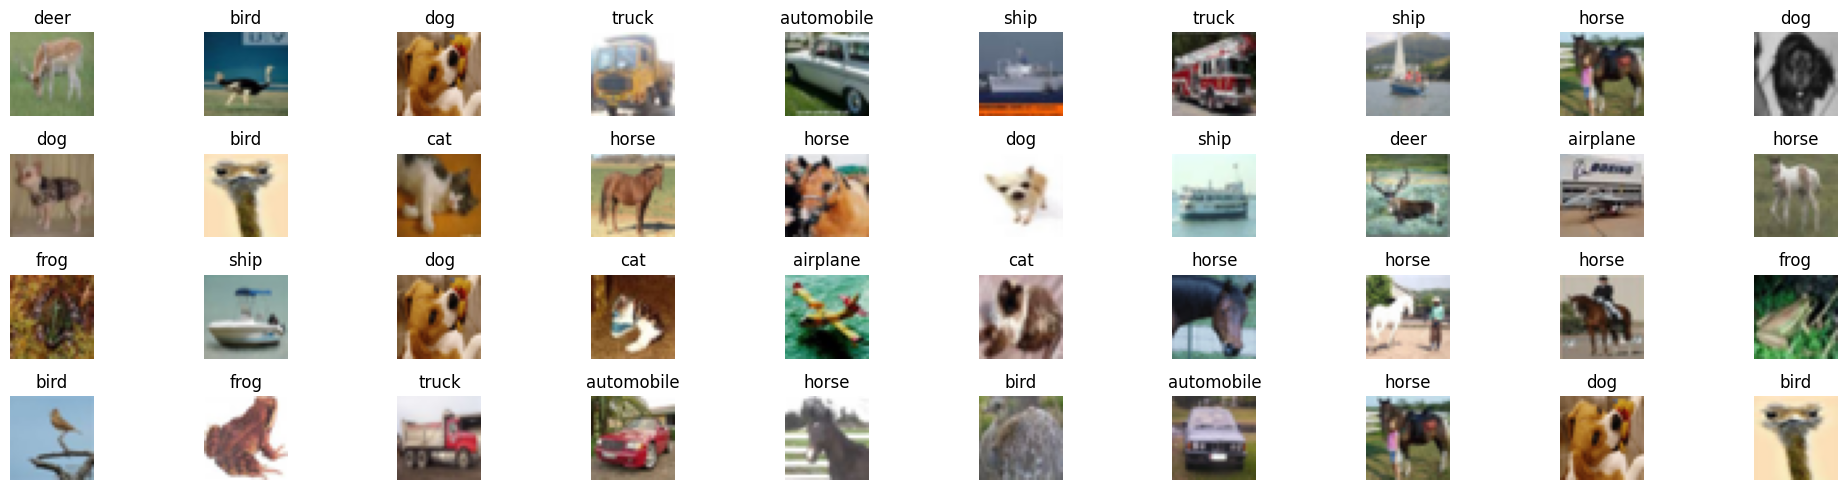

In [10]:
'''
You should be able to see some sample images from the training set if you correctly implemented the above code.
'''
def draw_sample_images(data, labels):
    nrows = 4
    ncols = 10
    total_image = data.shape[0]
    samples = np.random.choice(total_image, nrows*ncols)
    plt.figure(figsize=(20, 5))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        image = np.moveaxis(data[samples[i]].numpy(), 0, -1)
        plt.imshow(image/2+0.5)
        plt.title(trainset.classes[labels[samples[i]]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

data_iterator = iter(trainloader)
images, labels = next(data_iterator)
draw_sample_images(images, labels)

In [11]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Question: What's the shape of data in train_loader for a sigle batch? (in terms of [N, C, H, W])

### Part 2: Building the model


The "highlight" of EfficientNet is its use of compound scaling methods. Compound scaling in essence is to use a coefficient to uniformaly scale the 3 Dimensions (depth, width and resolution) of the model. The coefficient is denoted as $\phi$ in the paper. The scaling method is as follows:

$$
 \text{depth}: d = \alpha^\phi \\
 \text{width}: w = \beta^\phi \\
 \text{resolution}: r = \gamma^\phi \\
 \alpha \cdot \beta^2 \cdot \gamma ^2 \approx 2\\
\alpha \geq 1, \beta \geq 1, \gamma \geq 1
$$ 

The author created a family of EfficientNet models with different $\phi$ values, and the largest model is EfficientNet-B7 with $\phi = 2.0$. In this HW, we're going to implement EfficientNet, with the ability to scale from $b0$ to $b7$.

Firstly we'going to implement some tricks the author used that makes EfficientNet efficient. The first technique is called Squeeze and Excitation (SE). SE is very similiar to the attention mechanism. It is used to help the model to focus on the most important features. The SE module is implemented as follows: 

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/SE.jpeg?raw=1)

In [24]:
# Implement the Squueze and Excitation block down below
# Note that though the image above shows we're using ReLu as the activation function, we're actually using SiLU (swish)
# as the author mentioned in the paper that it performed better than ReLU. We also replace the avgpool with adaptiveavgpool
# for the same reason.
# Hint: use nn.AdaptiveAvgPool2d(1) to replace nn.AvgPool2d(1) and nn.SiLU() to replace nn.ReLU()
class SqueezeExcitation(nn.Module):
    def __init__(self, n_in, reduced_dim, fixed_params=False):
        super(SqueezeExcitation, self).__init__()
        self.conv1 = nn.Conv2d(n_in, reduced_dim, kernel_size=1)
        self.conv2 = nn.Conv2d(reduced_dim, n_in, kernel_size=1)
        if fixed_params:
          init.constant_(self.conv1.weight, 0.01)
          init.constant_(self.conv1.bias, 0.0)
          init.constant_(self.conv2.weight, 0.01)
          init.constant_(self.conv2.bias, 0.0)
        '''
        Hints: follow the pipeline in the image above to implement the forward pass of the Squeeze and Excitation block.
        use nn.Sequential() to build the block.
        '''
        #######################
        # TODO: your code here#
        #######################
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            self.conv1,
            nn.SiLU(),
            self.conv2,
            nn.Sigmoid()
        )
        #######################
        # End of your code    #
        #######################
    
    def forward(self, x):
        '''
        Hints: one line of code
        '''
        #######################
        # TODO: your code here#
        #######################
        y = self.se(x)
        #######################
        # End of your code    #
        #######################
        # Hint: consider why what the picture means by scaling and why we're multiplying here
        return x * y

In [25]:
# unit test for se
def test_se():
  data_iterator = iter(testloader)
  images, labels = next(data_iterator)
  x = images[0]
  se = SqueezeExcitation(3,2,fixed_params = True)
  y = se(x)
  y_test = y[0][0][:5].detach()
  y_true = torch.tensor([0.1196, 0.1235, 0.1471, 0.1510, 0.1274])
  assert torch.allclose(y_test,y_true,atol = 1e-3)
test_se()

tensor([0.1196, 0.1235, 0.1471, 0.1510, 0.1274])


Next we're going to implement the trick: Stochastic Depth, which makes the entire training process much faster. The gist of it is to randomly drop a subset of layers and bypass them with the identity function during training. And a full network is used during testing/inference. 

The image below shows the implementation of Stochastic Depth, we suggest lo

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/SD.jpeg?raw=1)

In [26]:
# Implement the Stochastic Depth block down below
# Hint: use torch.rand() to generate a random number

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8, fixed_params=False):
        super(StochasticDepth, self).__init__()
        self.fixed_params = fixed_params
        self.p =  survival_prob
        
    def forward(self, x):
        '''
        Hints: what happens when self.training is True? What shall we do when self.training is False?
        The idea is kind of similiar to Dropout and Masking.
        '''
        if self.fixed_params:
          if torch.cuda.is_available():
              torch.cuda.manual_seed(10)
          else:
              torch.manual_seed(10)
        #######################
        # TODO: your code here#
        #######################
        if not self.training:
            return x
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        return torch.div(x, self.p) * binary_tensor
        #######################
        # End of your code    #
        #######################

In [27]:
# unit test for stochastic depth
def test_sd():
  data_iterator = iter(testloader)
  images, labels = next(data_iterator)
  x = images[0]
  sd = StochasticDepth(fixed_params = True)
  y = sd(x)
  y_test = y[0][0][0][:5].detach()
  y_true = torch.tensor([0.2990, 0.3088, 0.3676, 0.3775, 0.3186])
  assert torch.allclose(y_test,y_true,atol = 1e-3)
test_sd()

In [36]:
# Here we provide you with the simple Conv-BatchNorm-Activation block for you
# Note that we're using SiLU (swish) as the activation function instead of ReLU as the author mentioned in the paper 
# that it performed better than ReLU

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False, fixed_params = False
                ):
        
        super(ConvBnAct, self).__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        if fixed_params:
          init.constant_(self.conv.weight, 0.01)
        if bias:
          init.constant_(self.conv.bias, 0.0)
          
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x

Finally here come the finally implementation of EfficientNet. Some additional tricks the author used here include Depthwise Separable Convolution, which is a combination of depthwise convolution and pointwise convolution. The depthwise convolution is used to extract features from each channel, and the pointwise convolution is used to combine the features from different channels.

The image below shows the implementation of Depthwise Separable Convolution, we suggest referencing this image when performing the implementation:

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/DSC.jpeg?raw=1)

In [38]:
# We start by implementing Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
# with Squeeze and Excitation Block and Stochastic Depth. 
# The process of implementation: residual -> exapnd -> depthwise conv 
# -> squeeze and excitation -> pointwise conv -> skip connection

class MBConvN(nn.Module):
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8, # Stochastic Depth
                 fixed_params = False
                ):
        
        super(MBConvN, self).__init__()
        '''
        Hints: self.skip_connection is True if stride == 1 and n_in == n_out

        For self.expand, you can use nn.Identity() if expansion_factor == 1 else ConvBnAct(). Check the original paper 
        for more details for the parameter you are going to use.

        For self.depthwise_conv, you can use ConvBnAct() with the correct parameters.

        self.se is something you implemented above.

        self.pointwise_conv is similar to self.depthwise_conv, but with different parameters.

        self.drop_layers is something you implemented above as well.
        '''
        #######################
        # TODO: your code here#
        #######################
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1, fixed_params = fixed_params)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels, fixed_params = fixed_params
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim, fixed_params = fixed_params)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False, fixed_params = fixed_params 
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob, fixed_params = fixed_params)
        #######################
        # End of your code    #
        #######################
        
    def forward(self, x):
        residual = x
        '''
        Hints: if self.skip_connection is True, you should add residual to x before returning it.
        Recollect the pipline of the MBConvN: residual -> exapnd -> depthwise conv -> squeeze and excitation 
        -> pointwise conv -> skip connection
        '''
        #######################
        # TODO: your code here#
        #######################
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        #######################
        # End of your code    #
        #######################
        return x


In [39]:
# Here comes the acutal implmentation of EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, width_mult = 1, depth_mult = 1, 
                dropout_rate = 0.2, num_classes = 1000, seed=42, fixed_params = False):
        super(EfficientNet, self).__init__()
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel, fixed_params)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(last_channel, num_classes)
        if fixed_params:
          init.constant_(self.fc1.weight, 0.01)
          init.constant_(self.fc1.bias, 0.0)
          self.classifier = nn.Sequential(
              self.fc1
          )
        else:
          self.classifier = nn.Sequential(
              nn.Dropout(dropout_rate),
              self.fc1
          )
        
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
    def _feature_extractor(self, width_mult, depth_mult, last_channel, fixed_params):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1, fixed_params=fixed_params)]
        in_channels = channels
        
        # These are from the paper
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        '''
        Hints: save all layers in the list `layers` and we will use nn.Sequential to wrap them up.
        You first use a for loop to iterate through all scaled number of layers. Then, for each iteration,
        you use another for loop to iterate through all scaled number of channels. For each iteration, you
        append a MBConvN block to the list `layers`. Note that the first MBConvN block in each iteration
        should have a stride of `strides[i]` and the rest should have a stride of 1. Also, the first MBConvN
        block in each iteration should have an input channel of `in_channels` and the rest should have an input
        channel of `scaled_num_channels[i]`. After each iteration, you update `in_channels` to be
        `scaled_num_channels[i]`.
        '''
        #######################
        # TODO: your code here#
        #######################
        for i in range(len(scaled_num_channels)):
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                            scaled_num_channels[i],
                            kernel_size = kernels[i],
                            stride = strides[i] if repeat==0 else 1, 
                            expansion_factor = expansions[i],
                            fixed_params = fixed_params
                            )
                    for repeat in range(scaled_num_layers[i])
                    ]
            in_channels = scaled_num_channels[i]
        #######################
        # End of your code    #
        #######################
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0, fixed_params = fixed_params))
    
        return nn.Sequential(*layers)

In [40]:
# unit test for efficientnet
def test_efficientnet():
  data_iterator = iter(testloader)
  images, labels = next(data_iterator)
  x = images[:2]
  net = EfficientNet(fixed_params=True)
  y = net(x)
  y_test = y[:,0].detach()
  y_true = torch.tensor([-3.4425,  9.3575])
  assert torch.allclose(y_test,y_true,atol = 1e-3)

test_efficientnet()

In [41]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    # from the paper
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

Finally we're going to train our implemented model. Follow the code instruction below to train the model. We recommend to use GPU to train the model. 

In [42]:
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
    # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    track_training_loss = []
    track_val_loss = []
    track_val_acc = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in trainloader:

            '''
            Load data to device.
            Hints: use .to(device) to load data to device
            remember to zero the parameter gradients
            '''
            #######################
            # TODO: your code here#
            #######################
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            #######################
            # End of your code    #
            #######################

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            '''
            Loss and Backpropagation.
            Hints: use criterion to calculate loss
            remember to perform backpropagation
            '''
            #######################
            # TODO: your code here#
            #######################
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #######################
            # End of your code    #
            #######################
            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(trainset)
        epoch_accuracy = running_accuracy/len(trainset)
        track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, valloader, len(val_ds), criterion)
        track_val_loss.append(val_loss) 
        track_val_acc.append(val_accuracy)
        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model, track_val_loss, track_val_acc

In [43]:
device = torch.device('cuda')

NUM_OF_CLASSES = 10
BATCH_SIZE = 32
NUM_OF_EPOCHS = 30

# Initialize Efficientnet model
# We are training the b2 version here
version = 'b2'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)


exp_lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(trainloader), epochs=NUM_OF_EPOCHS)

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/30
------------------------------
Training Loss: 1.6205 Training Acc.: 0.1915
Found better model...
Updating the model weights....

Val Loss: 1.7733 Val Acc.: 0.3218


Epoch 2/30
------------------------------
Training Loss: 1.3543 Training Acc.: 0.2933
Found better model...
Updating the model weights....

Val Loss: 1.5587 Val Acc.: 0.4173


Epoch 3/30
------------------------------
Training Loss: 1.2134 Training Acc.: 0.3558
Found better model...
Updating the model weights....

Val Loss: 1.4404 Val Acc.: 0.4756


Epoch 4/30
------------------------------
Training Loss: 1.1185 Training Acc.: 0.3906
Found better model...
Updating the model weights....

Val Loss: 1.3485 Val Acc.: 0.5083


Epoch 5/30
------------------------------
Training Loss: 1.0529 Training Acc.: 0.4194
Found better model...
Updating the model weights....

Val Loss: 1.2764 Val Acc.: 0.5401


Epoch 6/30
------------------------------
Training Loss: 0.9913 Training Acc.: 0.4442
Found better model...
Updating th

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
can only test a child process
    if w.is_alive():
Exception ignored

Training Loss: 0.5604 Training Acc.: 0.6030
Found better model...
Updating the model weights....

Val Loss: 0.9144 Val Acc.: 0.6842


Epoch 20/30
------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training Loss: 0.5360 Training Acc.: 0.6127


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Found better model...
Updating the model weights....

Val Loss: 0.9070 Val Acc.: 0.6954


Epoch 21/30
------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e9a326050>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():AssertionError
  File "/usr/lib/python3.10/multiprocessing/proce

Training Loss: 0.5195 Training Acc.: 0.6168

Epoch 22/30
------------------------------
Training Loss: 0.4994 Training Acc.: 0.6243
Found better model...
Updating the model weights....

Val Loss: 0.8707 Val Acc.: 0.7037


Epoch 23/30
------------------------------
Training Loss: 0.4795 Training Acc.: 0.6339

Epoch 24/30
------------------------------
Training Loss: 0.4686 Training Acc.: 0.6354
Found better model...
Updating the model weights....

Val Loss: 0.8781 Val Acc.: 0.7060


Epoch 25/30
------------------------------
Training Loss: 0.4583 Training Acc.: 0.6394

Epoch 26/30
------------------------------
Training Loss: 0.4336 Training Acc.: 0.6477

Epoch 27/30
------------------------------
Training Loss: 0.4254 Training Acc.: 0.6508
Found better model...
Updating the model weights....

Val Loss: 0.8840 Val Acc.: 0.7103


Epoch 28/30
------------------------------
Training Loss: 0.3997 Training Acc.: 0.6605

Epoch 29/30
------------------------------
Training Loss: 0.3868 Trainin

Question: What is the best accuracy you can get? What is the best accuracy you can get with the same number of parameters as the EfficientNet-B2 model? Feel free to use different models and find the one with the best validation accuracy.

In [44]:
def train_model(model):
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)


  exp_lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                              steps_per_epoch=len(trainloader), epochs=NUM_OF_EPOCHS)

  best_model, val_losses, val_accs = train(model = model,
                    criterion = criterion,
                    optimizer = optimizer,
                    scheduler = exp_lr_scheduler,
                    num_of_epochs = NUM_OF_EPOCHS
                    )
  
  val_loss, val_accuracy = calculate_loss_and_accuracy(best_model, valloader, len(val_ds), criterion)
  print("final validation statistics, loss : %s, accuracy : %s" %(val_loss, val_accuracy))

  return best_model, val_losses, val_accs

Now, let us compare with some other recent architecture models, which torchvision conveniently packages. Generally, we want to consider 2 things, the number of parameters, and the actual performance of the architecture.

For this, let us consider densenet121, mobilenetv2 and resNet50 which are all fairly recent models.

**Warning: this part takes roughly half an hour to train**

In [45]:
densenet121 = torchvision.models.densenet121(weights = False).to(device)
mobilenetv2 = torchvision.models.mobilenet_v2(weights = False).to(device)
resNet50 = torchvision.models.resnet50(weights = False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [46]:
def calculate_parameters(model, model_name):
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("%s has %s params" %(model_name, num_params))
  return num_params

In [47]:
dense_params = train_model(densenet121)


Epoch 1/30
------------------------------
Training Loss: 1.4407 Training Acc.: 0.3436
Found better model...
Updating the model weights....

Val Loss: 1.3945 Val Acc.: 0.4979


Epoch 2/30
------------------------------
Training Loss: 0.9452 Training Acc.: 0.4592
Found better model...
Updating the model weights....

Val Loss: 1.1795 Val Acc.: 0.5797


Epoch 3/30
------------------------------
Training Loss: 0.8057 Training Acc.: 0.5131
Found better model...
Updating the model weights....

Val Loss: 1.0660 Val Acc.: 0.6181


Epoch 4/30
------------------------------
Training Loss: 0.7102 Training Acc.: 0.5477
Found better model...
Updating the model weights....

Val Loss: 1.0133 Val Acc.: 0.6399


Epoch 5/30
------------------------------
Training Loss: 0.6251 Training Acc.: 0.5800
Found better model...
Updating the model weights....

Val Loss: 0.9901 Val Acc.: 0.6562


Epoch 6/30
------------------------------
Training Loss: 0.5536 Training Acc.: 0.6054
Found better model...
Updating th

In [48]:
mobile_params = train_model(mobilenetv2)


Epoch 1/30
------------------------------
Training Loss: 1.8835 Training Acc.: 0.1552
Found better model...
Updating the model weights....

Val Loss: 2.0235 Val Acc.: 0.2370


Epoch 2/30
------------------------------
Training Loss: 1.5204 Training Acc.: 0.2223
Found better model...
Updating the model weights....

Val Loss: 1.8410 Val Acc.: 0.3111


Epoch 3/30
------------------------------
Training Loss: 1.3917 Training Acc.: 0.2807
Found better model...
Updating the model weights....

Val Loss: 1.7202 Val Acc.: 0.3629


Epoch 4/30
------------------------------
Training Loss: 1.2973 Training Acc.: 0.3196
Found better model...
Updating the model weights....

Val Loss: 1.6093 Val Acc.: 0.4031


Epoch 5/30
------------------------------
Training Loss: 1.2253 Training Acc.: 0.3482
Found better model...
Updating the model weights....

Val Loss: 1.5614 Val Acc.: 0.4195


Epoch 6/30
------------------------------
Training Loss: 1.1690 Training Acc.: 0.3655
Found better model...
Updating th

In [49]:
res_params = train_model(resNet50)


Epoch 1/30
------------------------------
Training Loss: 1.6549 Training Acc.: 0.2270
Found better model...
Updating the model weights....

Val Loss: 1.7677 Val Acc.: 0.3719


Epoch 2/30
------------------------------
Training Loss: 1.2636 Training Acc.: 0.3439
Found better model...
Updating the model weights....

Val Loss: 1.5424 Val Acc.: 0.4548


Epoch 3/30
------------------------------
Training Loss: 1.1139 Training Acc.: 0.4022
Found better model...
Updating the model weights....

Val Loss: 1.4477 Val Acc.: 0.4837


Epoch 4/30
------------------------------
Training Loss: 1.0128 Training Acc.: 0.4433
Found better model...
Updating the model weights....

Val Loss: 1.3754 Val Acc.: 0.5207


Epoch 5/30
------------------------------
Training Loss: 0.9318 Training Acc.: 0.4712
Found better model...
Updating the model weights....

Val Loss: 1.3383 Val Acc.: 0.5310


Epoch 6/30
------------------------------
Training Loss: 0.8504 Training Acc.: 0.5005
Found better model...
Updating th

In [51]:
den_model, den_losses, den_acc = dense_params
mobile_model, mobile_losses, mobile_acc = mobile_params
res_model, res_losses, res_acc = res_params

In [52]:
den_acc = np.array([i.to('cpu').numpy() for i in den_acc])
mobile_acc = np.array([i.to('cpu').numpy() for i in mobile_acc])
res_acc = np.array([i.to('cpu').numpy() for i in res_acc])

In [53]:
best_model, efficientnet_val_losses, efficientnet_val_accs = best_model
efficientnet_val_accs = np.array([i.to('cpu').numpy() for i in efficientnet_val_accs])

Let us see how EfficientNet performs against them!

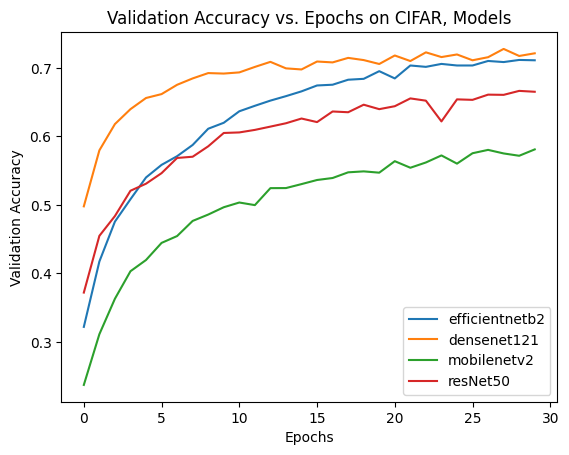

In [55]:
plt.plot(range(NUM_OF_EPOCHS), efficientnet_val_accs, label = 'efficientnetb2')
plt.plot(range(NUM_OF_EPOCHS), den_acc, label = 'densenet121')
plt.plot(range(NUM_OF_EPOCHS), mobile_acc, label = 'mobilenetv2')
plt.plot(range(NUM_OF_EPOCHS), res_acc, label = 'resNet50')
plt.title("Validation Accuracy vs. Epochs on CIFAR, Models")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

Question: Looking at the accuracy of EfficientNet compared to other state-of-the-art model architectures, how does the validation accuracy compare? Anything else interesting you've noticed about these plots?

We now examine the number of parameters within the different models. We provide a calculate_parameters function to just sum all the parameters for a model. We also provide some code for a quick bar plot.

In [56]:
def calculate_parameters(model, model_name):
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("%s has %s params" %(model_name, num_params))
  return num_params

In [57]:
eff_num_params = calculate_parameters(best_model, "efficientnetb2")
den_num_params = calculate_parameters(den_model, "densenet121")
mob_num_params = calculate_parameters(mobile_model, "mobilenetv2")
res_num_params = calculate_parameters(res_model, "resNet50")

efficientnetb2 has 4872811 params
densenet121 has 7978856 params
mobilenetv2 has 3504872 params
resNet50 has 25557032 params


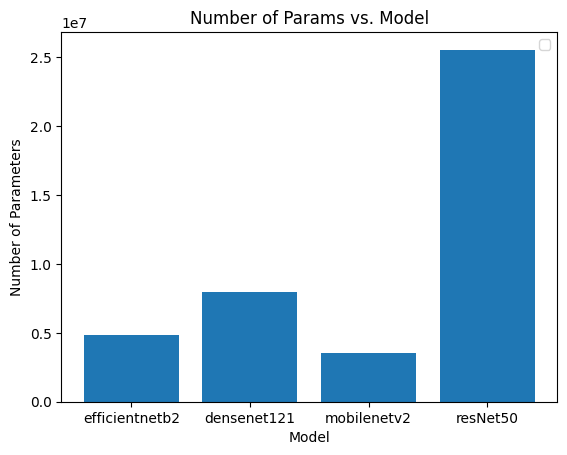

In [58]:
plt.bar(['efficientnetb2', 'densenet121', 'mobilenetv2', 'resNet50'], [eff_num_params, den_num_params, mob_num_params, res_num_params])
plt.legend()
plt.title("Number of Params vs. Model")
plt.xlabel("Model")
plt.ylabel("Number of Parameters")
plt.show()

Question: Examine the number of parameters of the different models, does anything stand out to you? If we take this as context, is there anything you want to comment about the validation performance of the models?

This is the end of the notebook. We hope you've learned something about EfficientNet!


## References

[1] Mingxing Tan, Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. https://arxiv.org/abs/1905.11946